In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import mode


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier



In [27]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')
submission = pd.read_csv('./dataset/sample_submission.csv')

print(f"Train: {train.shape} \nTest: {test.shape} \nSubmission: {submission.shape}")


Train: (4000000, 56) 
Test: (1000000, 55) 
Submission: (1000000, 2)


In [28]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0,3189,40,8,30,13,3270,206,234,193,...,0,0,0,0,0,0,0,0,0,1
1,1,3026,182,5,280,29,3270,233,240,106,...,0,0,0,0,0,0,0,0,0,2
2,2,3106,13,7,351,37,2914,208,234,137,...,0,0,0,0,0,0,0,0,0,1
3,3,3022,276,13,192,16,3034,207,238,156,...,0,0,0,0,0,0,0,0,0,2
4,4,2906,186,13,266,22,2916,231,231,154,...,0,0,0,0,0,0,0,0,0,2


In [29]:
test.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,4000000,2763,78,20,377,88,3104,218,213,195,...,0,0,0,0,0,0,0,0,0,0
1,4000001,2826,153,11,264,39,295,219,238,148,...,0,0,0,0,0,0,0,0,0,0
2,4000002,2948,57,19,56,44,852,202,217,163,...,0,0,1,0,0,0,0,0,0,0
3,4000003,2926,119,6,158,134,2136,234,240,142,...,0,0,0,0,0,0,0,0,0,0
4,4000004,2690,10,4,38,108,3589,213,221,229,...,0,0,0,0,0,0,0,0,0,0


In [30]:
train_target = train['Cover_Type']

train.drop(['Id', 'Cover_Type'], axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)


In [ ]:
train.describe().T.sort_values(by='std', ascending=False)

In [32]:
categorical_features = [col for col in train.columns if train[col].nunique() < 30]
continues_features = [col for col in train.columns if train[col].nunique() > 30]

print(f'Categorical Features: {len(categorical_features), categorical_features}, \n\nContinues Features: {len(continues_features), continues_features}')


Categorical Features: (44, ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']), 

Continues Features: (10, ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'])


### Plot Continues Distributions

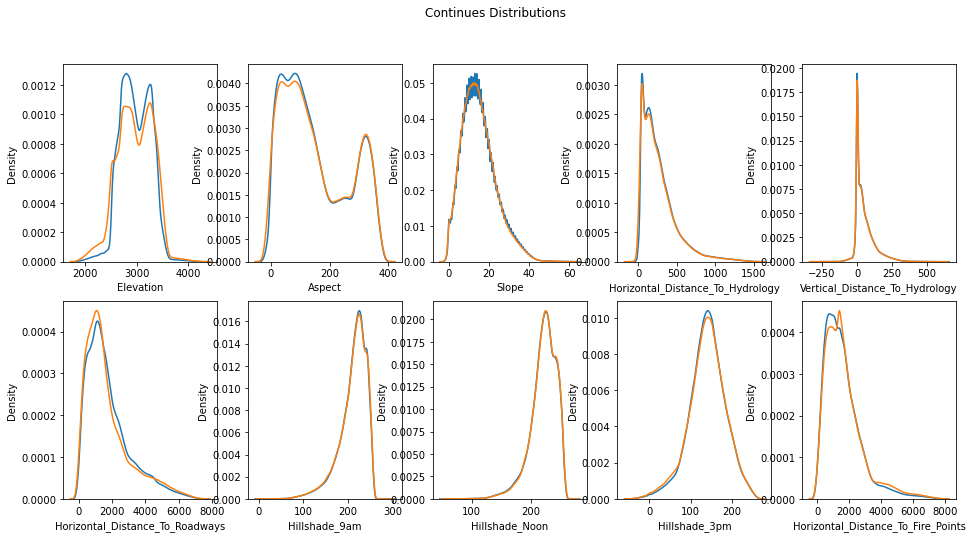

In [45]:
fig, ax = plt.subplots(2, 5, figsize=(16, 8))
fig.suptitle('Continues Distributions')

for i, col_name in enumerate(continues_features):
    sns.kdeplot(train[col_name], ax=ax[i//5, i%5], label='Train')
    sns.kdeplot(test[col_name], ax=ax[i//5, i % 5], label='Test')
    

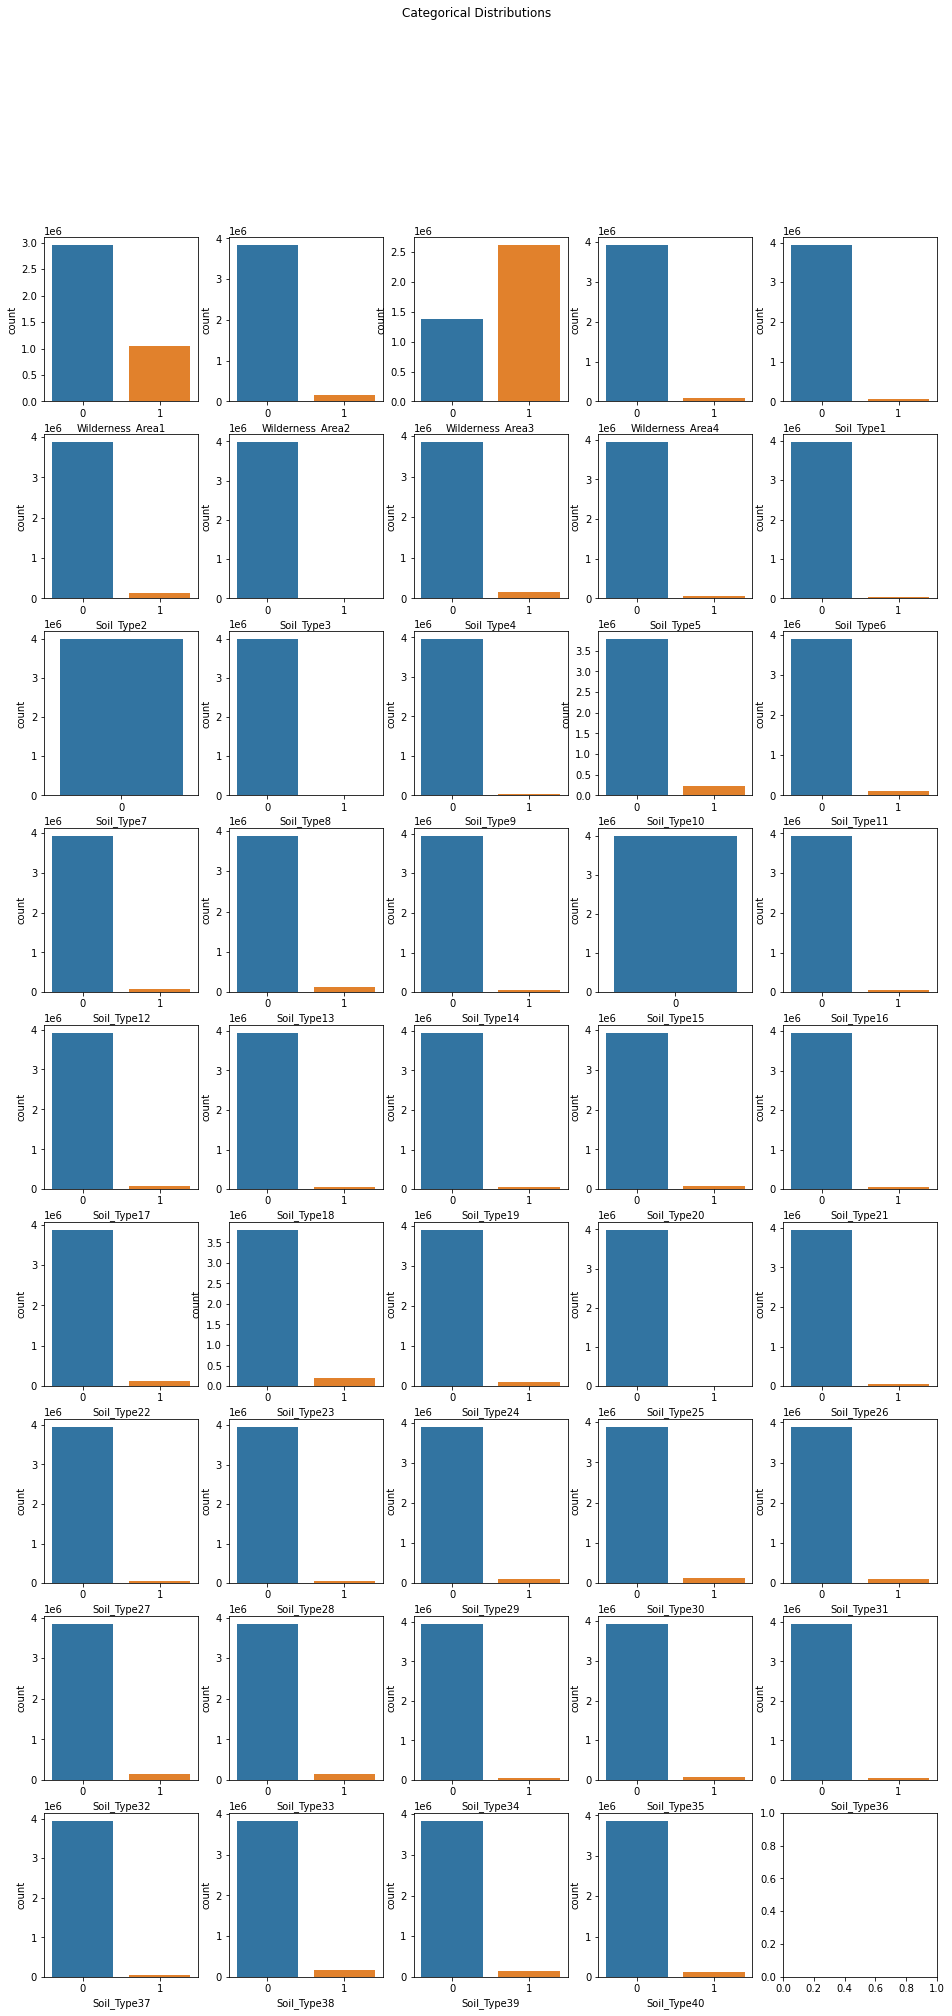

In [79]:
fig, ax = plt.subplots(9, 5, figsize=(16, 32))
fig.suptitle('Categorical Distributions')

for i, col_name in enumerate(categorical_features):
    sns.countplot(x=train[col_name], ax=ax[i//5, i % 5], label='Train')
    # sns.countplot(x=test[col_name], ax=ax[i//5, i % 5], label='Test')


   index  Cover_Type
0      2     2262087
1      1     1468136
2      3      195712
3      7       62261
4      6       11426
5      4         377
6      5           1


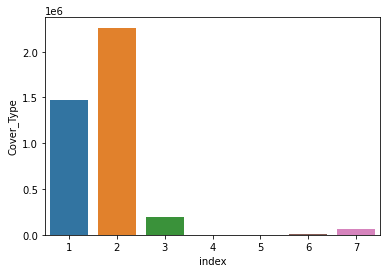

In [33]:
target_counts = train_target.value_counts().reset_index()
sns.barplot(y='Cover_Type', x='index', data=target_counts)
print(target_counts)


### Removing Unnecessary Columns

In [47]:
train.drop(index=train_target[train_target==5].index, inplace=True)
train_target.drop(index=train_target[train_target==5].index, inplace=True)
train = train.drop(labels=['Soil_Type7', 'Soil_Type15'], axis=1)
test = test.drop(labels=['Soil_Type7', 'Soil_Type15'], axis=1)
categorical_features.remove('Soil_Type7')
categorical_features.remove('Soil_Type15')

### Scaling Data

In [35]:
scaler = StandardScaler()
for col in continues_features:
    train[col] = scaler.fit_transform(train[[col]])
    test[col] = scaler.transform(test[[col]])


In [48]:
X = train.to_numpy().astype(np.float32)
y = train_target.to_numpy().astype(np.float32)
X_test = test.to_numpy().astype(np.float32)


In [53]:
import warnings
warnings.filterwarnings("ignore")


In [54]:
lgb_params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
}

lgb_predictions = []
lgb_scores = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X=X, y=y)):

    print(10*"=", f"Fold={fold+1}", 10*"=")
    x_train = X[train_idx, :]
    x_valid = X[valid_idx, :]
    y_train = y[train_idx]
    y_valid = y[valid_idx]

    model = LGBMClassifier(**lgb_params)
    model.fit(x_train, y_train,
              early_stopping_rounds=200,
              eval_set=[(x_valid, y_valid)],
              verbose=0)

    preds_valid = model.predict(x_valid)
    acc = accuracy_score(y_valid,  preds_valid)
    lgb_scores.append(acc)
    print(f"Fold={fold+1}, acc: {acc:.8f}")
    test_preds = model.predict(X_test)
    lgb_predictions.append(test_preds)

print("Mean Accuracy :", np.mean(lgb_scores))


========== Fold=1 ==========
Fold=1, acc: 0.94726375
========== Fold=2 ==========
Fold=2, acc: 0.95060625
========== Fold=3 ==========
Fold=3, acc: 0.94680000
========== Fold=4 ==========
Fold=4, acc: 0.95533500
========== Fold=5 ==========
Fold=5, acc: 0.94860119
Mean Accuracy : 0.9497212371502964
